# Homework 2 - association rules

In this homework we will perform association between data series in the obesity dataset. For this notebook we will use the following formulas:

$$
\begin{align*}
    support(X) &= P(X) \\
            &= \frac{\text{number of instances containing X in the dataset}}{\text{total number of items in the dataset}} \\
    \\
    support(X \rightarrow Y) &= P(X \cap Y) \\
                            &= support(X \cup Y) \\
                            &= \frac{\text{number of instances containing both X and Y in the dataset}}{\text{total number of items in the dataset}} \\
    \\
    confidence(X \rightarrow Y) &= P(Y|X) = \frac{P(X \cap Y)}{P(X)} \\
                                &= \frac{support(X \cup Y)}{support(X)} \\
    \\
    lift(X \rightarrow Y) &= \frac{P(X \cap Y)}{P(X) \cdot P(Y)} \\
                          &= \frac{support(X \cup Y)}{support(X) \cdot support(Y)} \\
    \\
    conviction(X \rightarrow Y) &= \frac{1 - P(Y)}{1 - P(Y|X)} = \frac{1 - P(Y)}{1 - \frac{P(X \cap Y)}{P(X)}} \\
                                &= \frac{1 - support(Y)}{1 - confidence(X \rightarrow Y)} \\
\end{align*}
$$

We will use the Apriori and ECLAT algorithms.

## Conclusions

Using the Apriori algorithm, we gathered the following conclusions:
- for numerical - numerical attribute analysis:
  - With over average confidence (`0.67`) and low support (`0.27`), we can state that people that **consume many vegetables per day** also **consume more meals**
- for categorial - categorial attribute analysis:
  - Majority of the surveyed population **does not smoke** (support `0.97`, confidence `0.97`)
  - Majority of the surveyed population **does not perform calories monitoring** (support `0.95`, confidence `0.95`)
  - A good part of the surveyed population that **presents an overweight family member** reported **frequent consumption of high-caloric food** (support `0.74`, confidence `0.91`)
- for categorial + numerical - categorial + numerical attribute analysis:
  - With rather high confidence (`0.90`), but rather low support (`0.40`), people that **eat 3 meals per day**, **sometimes eat outside of meal hours** and **don't perform calorie monitoring** have **an overweight family member**

## Dependencies

### General dependencies

Imports for Python

In [2]:
import copy
import os
import platform

if platform.system() == "Windows":
    os.environ['R_HOME'] = 'C:\Program Files\R\R-4.3.3'

In [3]:
import typing as t
import csv
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import HTML, IFrame

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [4]:
import arulespy.arules as arules
import arulespy.arulesViz as arulesviz


In [5]:
import seaborn as sns
import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.ipython.ggplot import image_png
from arulespy.arulesViz import plot, inspectDT
from catscatter import catscatter

htmlwidgets = packages.importr("htmlwidgets")


### Dataset-specific dependencies

Dataset manager, known labels, known outputs for the dataset.

In [6]:
LABEL_VARIABLE = "NObeyesdad"
NUMERICAL_VARIABLES = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
CATEGORICAL_VARIABLES_NO_LABEL = [
    "FAVC",
    "CAEC",
    "CALC",
    "SCC",
    "MTRANS",
    "Gender",
    "family_history_with_overweight",
    "SMOKE",
]
CATEGORICAL_VARIABLES = [
    *CATEGORICAL_VARIABLES_NO_LABEL,
    LABEL_VARIABLE,
]
ALL_VARIABLES_NO_LABEL = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES_NO_LABEL]
ALL_VARIABLES = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES]
LABEL_DICTIONARY = {
    "Age": "Age",
    "Height": "Height (cm)",
    "Weight": "Weight (kg)",
    "FCVC": " Frequency of consumption of vegetables (times per day)",
    "NCP": "Number of main meals",
    "CH2O": "Consumption of water daily (Liters)",
    "FAF": "Physical activity frequency (times per day)",
    "TUE": "Time using technology devices (hours)",
    "FAVC": "Frequent consumption of high caloric food",
    "CAEC": "Consumption of food between meals",
    "CALC": "Consumption of alcohol",
    "SCC": "Calories consumption monitoring",
    "MTRANS": "Transportation used",
    "Gender": "Gender",
    "family_history_with_overweight": "Family member suffered or suffers from overweight",
    "SMOKE": "Smoker or not",
    "NObeyesdad": "Obesity level",
}

T = t.TypeVar("T")


class Person:
    Gender: str
    Age: np.int32
    Height: np.float32
    Weight: np.float32
    family_history_with_overweight: str
    FAVC: str
    FCVC: np.float32
    NCP: np.float32
    CAEC: str
    SMOKE: str
    CH2O: np.float32
    SCC: str
    FAF: np.float32
    TUE: np.float32
    CALC: str
    MTRANS: str
    NObeyesdad: str

    def __init__(
        self,
        Gender: str,
        Age: str,
        Height: str,
        Weight: str,
        family_history_with_overweight: str,
        FAVC: str,
        FCVC: str,
        NCP: str,
        CAEC: str,
        SMOKE: str,
        CH2O: str,
        SCC: str,
        FAF: str,
        TUE: str,
        CALC: str,
        MTRANS: str,
        NObeyesdad: str,
    ):
        self.Gender = Gender
        self.Age = np.float32(Age)
        self.Height = np.float32(Height)
        self.Weight = np.float32(Weight)
        self.family_history_with_overweight = family_history_with_overweight
        self.FAVC = FAVC
        self.FCVC = np.float32(FCVC)
        self.NCP = np.float32(NCP)
        self.CAEC = CAEC
        self.SMOKE = SMOKE
        self.CH2O = np.float32(CH2O)
        self.SCC = SCC
        self.FAF = np.float32(FAF)
        self.TUE = np.float32(TUE)
        self.CALC = CALC
        self.MTRANS = MTRANS
        self.NObeyesdad = NObeyesdad

    def __str__(self):
        return vars(self)

    def __len__(self):
        return len(vars(self))

    def __repr__(self):
        return vars(self)


class DatasetManager:
    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

    def load_as_obj_list(self) -> list[Person]:
        with open(self.path_to_csv) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            return [Person(**row) for row in csv_reader]

In [7]:
dataset_manager = DatasetManager("data/ObesityDataSet.csv")
dataset_obj_list = dataset_manager.load_as_obj_list()
dataset_dataframe = pd.DataFrame.from_records(
    data=[vars(entry) for entry in dataset_obj_list]
)

### Categorial data utility functions

Here we add utility functions (if any) for the categorial data types.

In [8]:
# TODO: add if any are found

### Continuous data utility functions

Here we add utility functions (if any) for the continuous data types.

In [9]:
def get_np_bins_and_labels(bins: list[tuple[float, float]]) -> tuple[np.array, list[str]]:
    return np.array(np.array(bins).T[0].tolist() + [bins[-1][1]]).astype(np.float32), [f"({lh}, {rh}]" for lh, rh in bins]


predifined_bins = {
    "Age": get_np_bins_and_labels([
        (0, 12),
        (12, 18),
        (18, 26),
        (26, 36),
        (36, 46),
        (46, 60),
        (60, 200)
    ]),
    "Weight": get_np_bins_and_labels([
        (0, 55),
        (55, 70),
        (70, 80),
        (80, 100),
        (100, 120),
        (120, 400)
    ]),
    "Height": get_np_bins_and_labels([
        (0, 1.62),
        (1.62, 1.75),
        (1.75, 3.00)
    ])
}

def bin_numerical_equally_by_frequency(
    data: t.Union[npt.NDArray[np.float32], npt.NDArray[np.int32]], bins: int = 30
):
    """
    Performs roughly equal binning based on the frequency of the items.
    Example: For data = [1, 2, 3, 4, 5, 6, 7, 8, 9] and bins = 3, result will be (1, 3], (3, 6], (6, 9]
    """

    if type(data[0]) is not np.float32 and type(data[0]) is not np.int32:
        return data

    result = pd.qcut(data, q=bins, duplicates="drop").astype("string")
    return result

def bin_on_predefined_way(data: t.Union[npt.NDArray[np.float32], npt.NDArray[np.int32]], predefined_bins: tuple[np.array, list[str]]):

    if type(data[0]) is not np.float32 and type(data[0]) is not np.int32:
        return data

    return pd.cut(data, bins=predefined_bins[0], labels=predefined_bins[1], include_lowest=True)

def bin_numerical_smartly(data_name: str, data: t.Union[npt.NDArray[np.float32], npt.NDArray[np.int32]], bins: int = 30):

    if data_name not in predifined_bins:
        return bin_numerical_equally_by_frequency(data, bins=bins)
    else:
        return bin_on_predefined_way(data, predifined_bins[data_name])


### Algorithm utility functions

Here we add utility functions for the algorithms to help us reduce code duplication.

In [10]:
def run_apriori(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> t.Optional[pd.DataFrame]:
    try:
        rules = arules.apriori(
            transactions,
            parameter=arules.parameters({"supp": support, "conf": confidence}),
            control=arules.parameters({"verbose": False}),
        )
        return rules.as_df()
    except:
        return None


def run_apriori_build_html(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> tuple[str, pd.DataFrame]:
    result = ""

    rules_dataframe = run_apriori(
        transactions=transactions, support=support, confidence=confidence
    )

    result += f"<h2>Result for Apriori run (support: {support}, confidence: {confidence})</h2>"
    result += (
        rules_dataframe.to_html()
        if rules_dataframe is not None
        else "<p>No rules were found</p>"
    )
    result += "</br>"

    return result, rules_dataframe


def run_eclat(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> t.Optional[pd.DataFrame]:
    try:
        rules = arules.eclat(
            transactions,
            parameter=arules.parameters({"supp": support}),
            control=arules.parameters({"verbose": False}),
        )
        return rules.as_df()
    except:
        return None


def run_eclat_build_html(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> tuple[str, pd.DataFrame]:
    result = ""

    rules_dataframe = run_eclat(
        transactions=transactions, support=support, confidence=confidence
    )

    result += f"<h2>Result for ECLAT run (support: {support})</h2>"
    result += (
        rules_dataframe.to_html()
        if rules_dataframe is not None
        else "<p>No rules were found</p>"
    )
    result += "</br>"

    return result, rules_dataframe

def data_frame_to_html(title: str, data_frame: pd.DataFrame) -> str:
    return f"<h2>{title}</h2></br>{data_frame.to_html()}</br>"

## Preliminary data analysis

Here we built plots for the data. Mostly for debugging purposes.

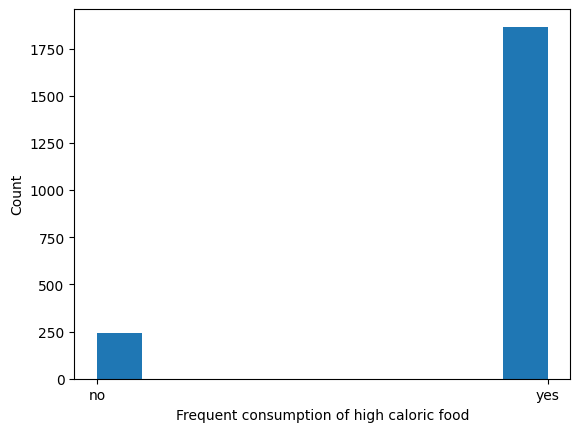

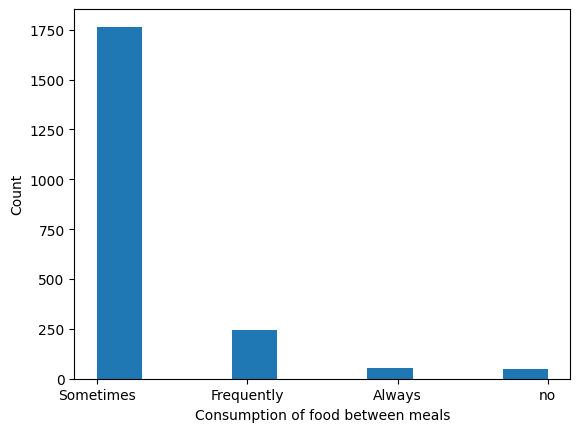

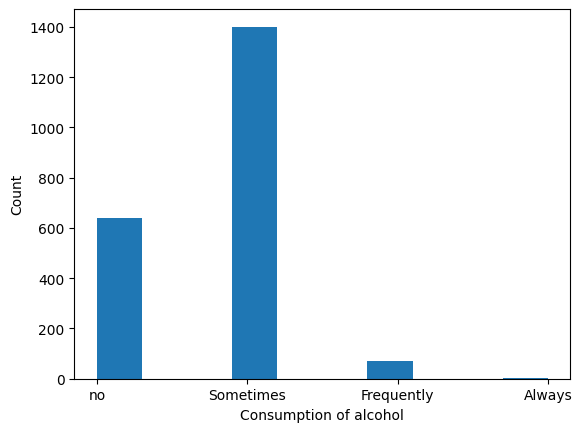

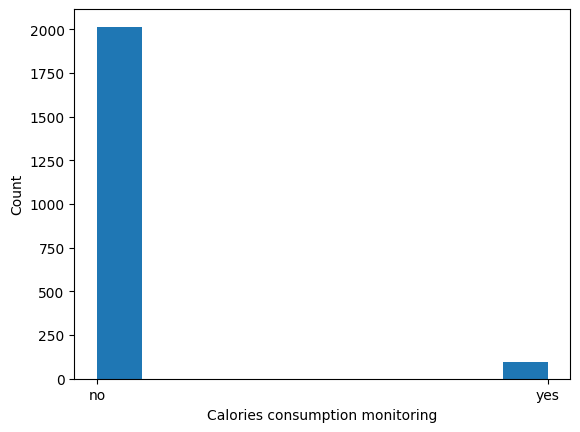

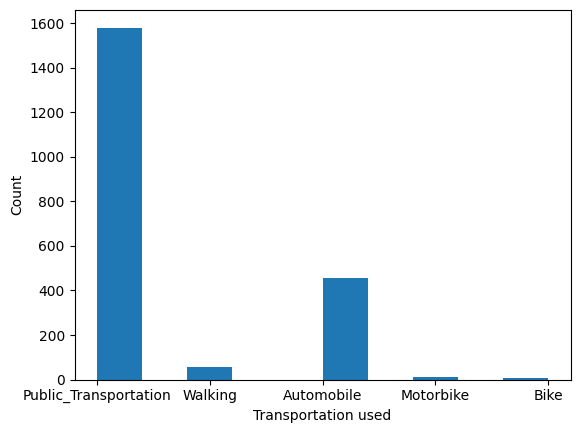

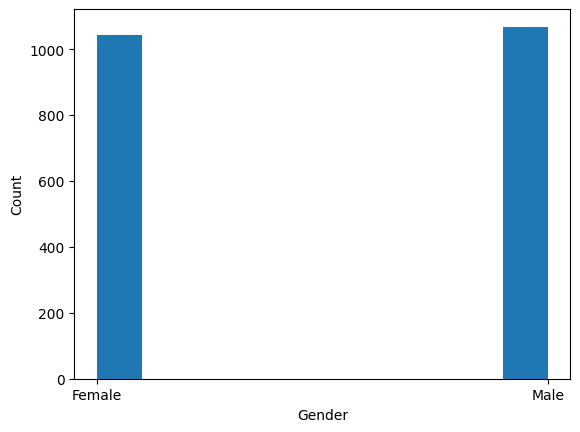

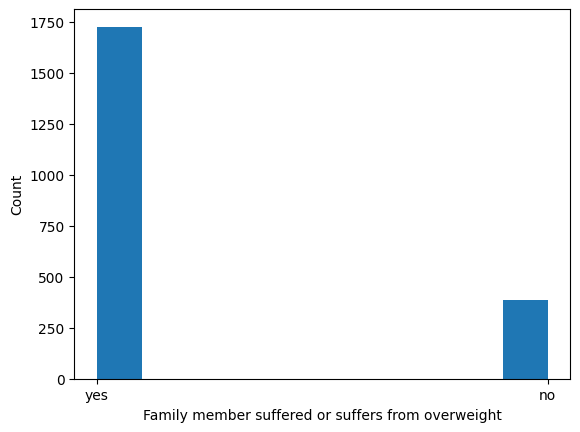

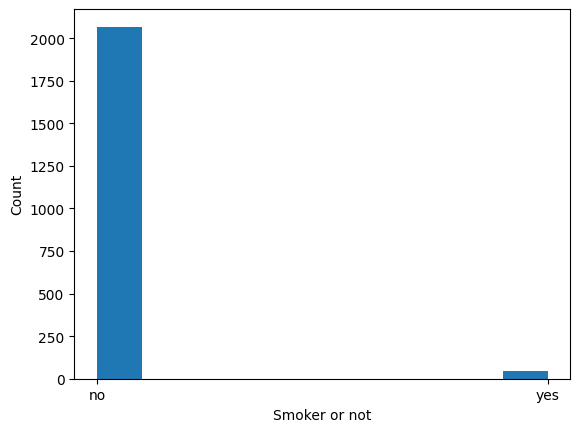

In [11]:
for label in CATEGORICAL_VARIABLES_NO_LABEL:
    pretty_label = LABEL_DICTIONARY[label]
    dataset_subset_dataframe = dataset_dataframe[label].astype(str)

    plt.figure()
    plt.hist(dataset_subset_dataframe)
    plt.xlabel(pretty_label)
    plt.ylabel("Count")
    plt.show()

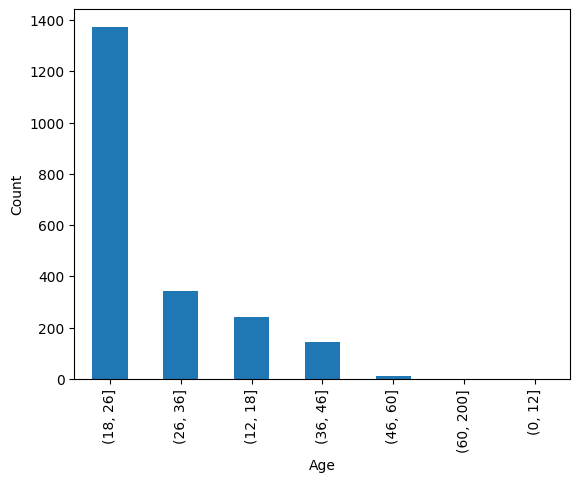

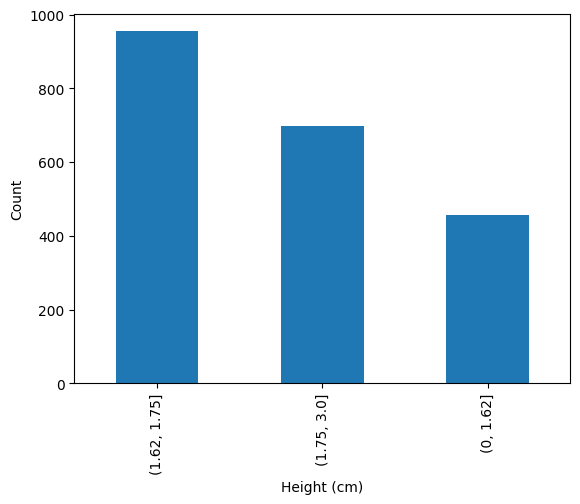

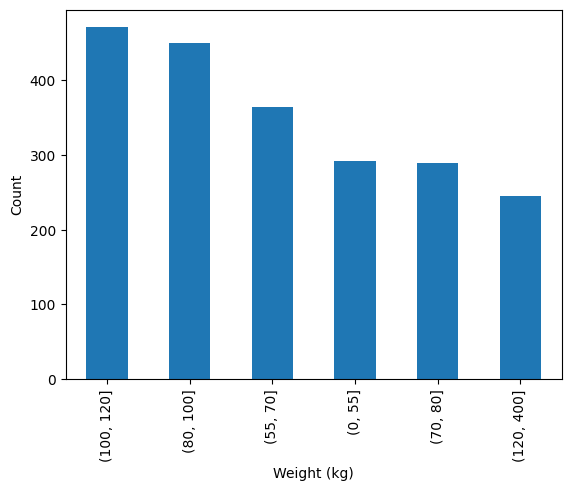

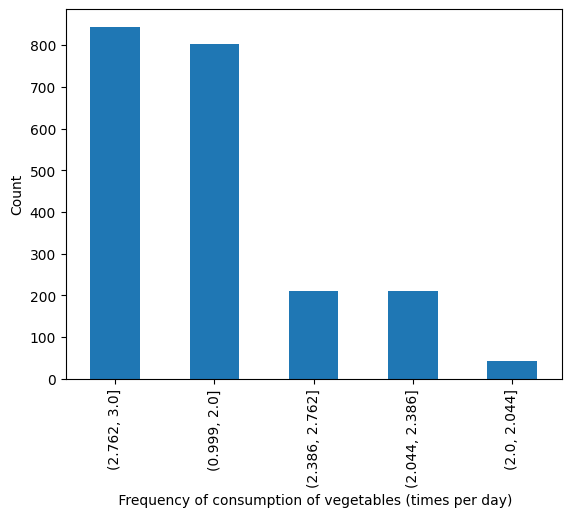

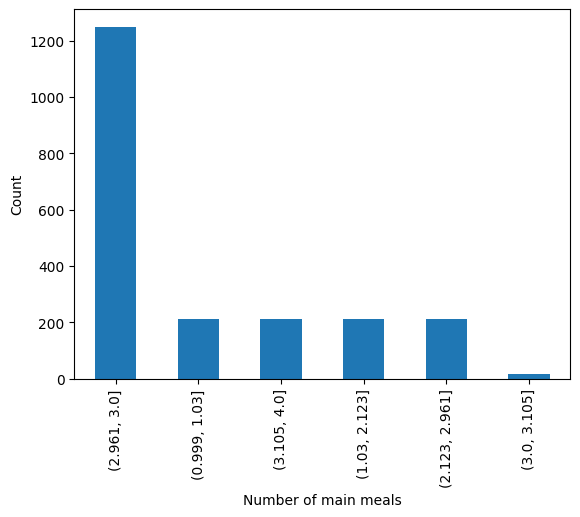

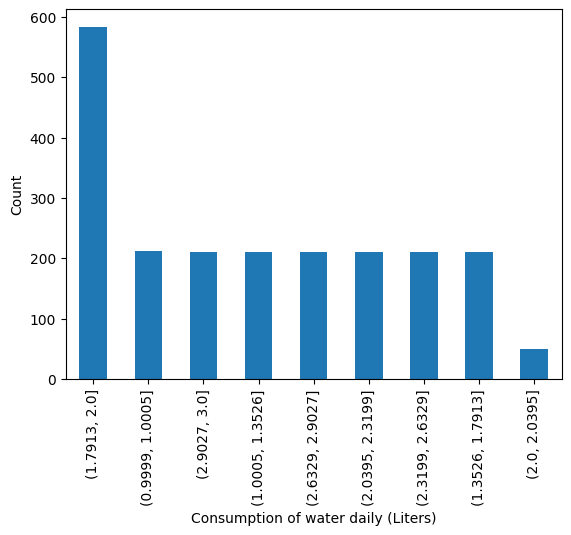

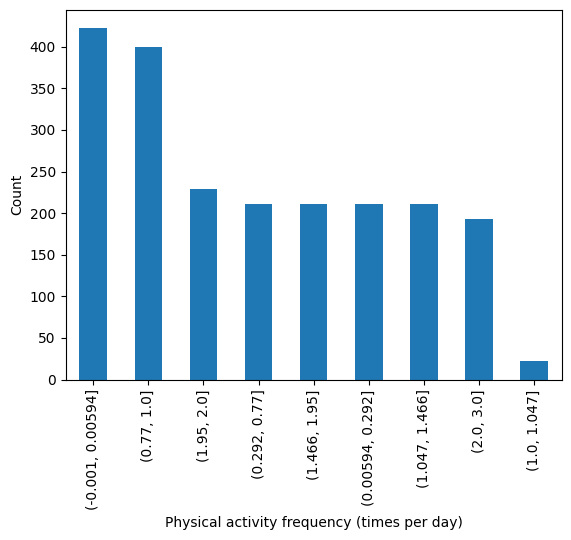

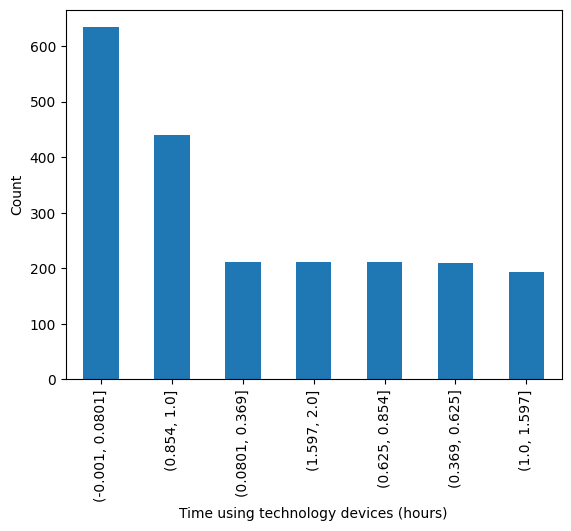

In [12]:
for label in NUMERICAL_VARIABLES:
    pretty_label = LABEL_DICTIONARY[label]
    dataset_subset_dataframe = dataset_dataframe[label].astype(np.float32)
    binned_data = bin_numerical_smartly(
        data_name=label,
        data=dataset_subset_dataframe, bins=10
    )

    plt.figure()
    binned_data.value_counts().plot(kind="bar", xlabel=label, ylabel="Count", rot=90)
    plt.xlabel(pretty_label)
    plt.ylabel("Count")
    plt.show()

## Finding association rules

Here we use the `arules` library to find association rules.

### Categorical - categorical associations with Apriori algorithm


In [13]:
parameters = [
    (0.7, 0.4),
    (0.8, 0.8),
    (0.9, 0.8),
    (0.9, 0.9),
    (0.95, 0.9),
    (0.95, 0.95),
]

dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
categorical_categorical_apriori = {}

for support, confidence in parameters:
    html_out, df_out = run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    categorical_categorical_apriori[(support, confidence)] = df_out

HTML(result_html)

,LHS,RHS,support,confidence,coverage,lift,count
1,{},{MTRANS=Public_Transportation},0.748460,0.748460,1.000000,1.000000,1580
2,{},{family_history_with_overweight=yes},0.817622,0.817622,1.000000,1.000000,1726
3,{},{CAEC=Sometimes},0.836097,0.836097,1.000000,1.000000,1765
4,{},{FAVC=yes},0.883941,0.883941,1.000000,1.000000,1866
5,{},{SCC=no},0.954524,0.954524,1.000000,1.000000,2015
6,{},{SMOKE=no},0.979157,0.979157,1.000000,1.000000,2067
7,{MTRANS=Public_Transportation},{SCC=no},0.713406,0.953165,0.748460,0.998576,1506
8,{SCC=no},{MTRANS=Public_Transportation},0.713406,0.747395,0.954524,0.998576,1506
9,{MTRANS=Public_Transportation},{SMOKE=no},0.734249,0.981013,0.748460,1.001895,1550
10,{SMOKE=no},{MTRANS=Public_Transportation},0.734249,0.749879,0.979157,1.001895,1550


### Categorial - categorial associations with ECLAT algorithm


In [14]:
parameters = [
    (0.7, 0.4),
    (0.8, 0.8),
    (0.9, 0.8),
    (0.9, 0.9),
    (0.95, 0.9),
    (0.95, 0.95),
]

dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
categorical_categorical_eclat = {}

for support, confidence in parameters:
    html_out, df_out = run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    categorical_categorical_eclat[(support, confidence)] = df_out

HTML(result_html)

,items,support,count
1,"{SCC=no,MTRANS=Public_Transportation,SMOKE=no}",0.701090,1480
2,"{MTRANS=Public_Transportation,SMOKE=no}",0.734249,1550
3,"{SCC=no,MTRANS=Public_Transportation}",0.713406,1506
4,"{CAEC=Sometimes,SCC=no,family_history_with_overweight=yes,SMOKE=no}",0.708195,1495
5,"{CAEC=Sometimes,family_history_with_overweight=yes,SMOKE=no}",0.719090,1518
6,"{CAEC=Sometimes,SCC=no,family_history_with_overweight=yes}",0.720512,1521
7,"{FAVC=yes,SCC=no,family_history_with_overweight=yes,SMOKE=no}",0.721459,1523
8,"{FAVC=yes,family_history_with_overweight=yes,SMOKE=no}",0.734723,1551
9,"{FAVC=yes,SCC=no,family_history_with_overweight=yes}",0.733775,1549
10,"{SCC=no,family_history_with_overweight=yes,SMOKE=no}",0.779725,1646


### Numerical - numerical associations with Apriori algorithm


In [15]:
parameters = [
    (0.2, 0.4),
    (0.25, 0.6),
]

dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries, label: bin_numerical_smartly(data_name=next(label), data=dataseries, bins=10),
    args=(iter(dataset_subset_dataframe.columns), )
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
numerical_numerical_apriori = {}

for support, confidence in parameters:
    html_out, df_out = run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    numerical_numerical_apriori[(support, confidence)] = df_out

HTML(result_html)

,LHS,RHS,support,confidence,coverage,lift,count
1,{},"{Height=(1.62, 1.75]}",0.452392,0.452392,1.000000,1.000000,955
2,{},"{NCP=(2.961, 3.0]}",0.591663,0.591663,1.000000,1.000000,1249
3,{},"{Age=(18, 26]}",0.649929,0.649929,1.000000,1.000000,1372
4,"{Height=(1.75, 3.0]}","{NCP=(2.961, 3.0]}",0.204169,0.616595,0.331123,1.042140,431
5,"{FCVC=(0.999, 2.0]}","{NCP=(2.961, 3.0]}",0.220275,0.579800,0.379915,0.979951,465
6,"{FCVC=(0.999, 2.0]}","{Age=(18, 26]}",0.245855,0.647132,0.379915,0.995697,519
7,"{FCVC=(2.762, 3.0]}","{Height=(1.62, 1.75]}",0.212222,0.530806,0.399811,1.173331,448
8,"{Height=(1.62, 1.75]}","{FCVC=(2.762, 3.0]}",0.212222,0.469110,0.452392,1.173331,448
9,"{FCVC=(2.762, 3.0]}","{NCP=(2.961, 3.0]}",0.271435,0.678910,0.399811,1.147461,573
10,"{NCP=(2.961, 3.0]}","{FCVC=(2.762, 3.0]}",0.271435,0.458767,0.591663,1.147461,573


### Numerical - numerical associations with ECLAT algorithm


In [16]:
parameters = [
    (0.2, 0.4),
    (0.25, 0.6),
]

dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries, label: bin_numerical_smartly(data_name=next(label), data=dataseries, bins=10),
    args=(iter(dataset_subset_dataframe.columns), )
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
numerical_numerical_eclat = {}

for support, confidence in parameters:
    html_out, df_out = run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    numerical_numerical_eclat[(support, confidence)] = df_out

HTML(result_html)

,items,support,count
1,"{Height=(1.75, 3.0],NCP=(2.961, 3.0]}",0.204169,431
2,"{Age=(18, 26],FCVC=(0.999, 2.0]}",0.245855,519
3,"{FCVC=(0.999, 2.0],NCP=(2.961, 3.0]}",0.220275,465
4,"{Age=(18, 26],FCVC=(2.762, 3.0],NCP=(2.961, 3.0]}",0.216485,457
5,"{Age=(18, 26],FCVC=(2.762, 3.0]}",0.299384,632
6,"{FCVC=(2.762, 3.0],NCP=(2.961, 3.0]}",0.271435,573
7,"{Height=(1.62, 1.75],FCVC=(2.762, 3.0]}",0.212222,448
8,"{Age=(18, 26],Height=(1.62, 1.75],NCP=(2.961, 3.0]}",0.222170,469
9,"{Age=(18, 26],Height=(1.62, 1.75]}",0.315017,665
10,"{Height=(1.62, 1.75],NCP=(2.961, 3.0]}",0.291805,616


### Categorical + numerical - categorical + numerical associations with Apriori algorithm


In [17]:
parameters = [
    (0.4, 0.9),
]

dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries, label: bin_numerical_smartly(data_name=next(label), data=dataseries, bins=10),
    args=(iter(dataset_subset_dataframe.columns), )
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
catnum_catnum_apriori = {}

for support, confidence in parameters:
    html_out, df_out = run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    catnum_catnum_apriori[(support, confidence)] = df_out

HTML(result_html)

,LHS,RHS,support,confidence,coverage,lift,count
1,{},{SCC=no},0.954524,0.954524,1.000000,1.000000,2015
2,{},{SMOKE=no},0.979157,0.979157,1.000000,1.000000,2067
3,"{Height=(1.62, 1.75]}",{SCC=no},0.438655,0.969634,0.452392,1.015829,926
4,"{Height=(1.62, 1.75]}",{SMOKE=no},0.444339,0.982199,0.452392,1.003107,938
5,{Gender=Female},{SCC=no},0.460919,0.932886,0.494079,0.977331,973
6,{Gender=Female},{SMOKE=no},0.486973,0.985618,0.494079,1.006599,1028
7,{Gender=Male},{FAVC=yes},0.457603,0.904494,0.505921,1.023252,966
8,{Gender=Male},{SCC=no},0.493605,0.975655,0.505921,1.022138,1042
9,{Gender=Male},{SMOKE=no},0.492184,0.972846,0.505921,0.993555,1039
10,"{NCP=(2.961, 3.0]}",{SCC=no},0.565135,0.955164,0.591663,1.000671,1193


### Categorical + numerical - categorical + numerical associations with ECLAT algorithm

In [18]:
parameters = [
    (0.4, 0.9),
]

dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries, label: bin_numerical_smartly(data_name=next(label), data=dataseries, bins=10),
    args=(iter(dataset_subset_dataframe.columns), )
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result_html = ""
catnum_catnum_eclat = {}

for support, confidence in parameters:
    html_out, df_out = run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )
    result_html += html_out
    catnum_catnum_eclat[(support, confidence)] = df_out

HTML(result_html)

,items,support,count
1,"{Height=(1.62, 1.75],SCC=no,SMOKE=no}",0.431549,911
2,"{Height=(1.62, 1.75],SMOKE=no}",0.444339,938
3,"{Height=(1.62, 1.75],SCC=no}",0.438655,926
4,"{Height=(1.62, 1.75],FAVC=yes}",0.402653,850
5,"{MTRANS=Public_Transportation,Gender=Female,SMOKE=no}",0.400284,845
6,"{FAVC=yes,SCC=no,Gender=Female,SMOKE=no}",0.401705,848
7,"{FAVC=yes,Gender=Female,SMOKE=no}",0.421601,890
8,"{FAVC=yes,SCC=no,Gender=Female}",0.405969,857
9,"{SCC=no,Gender=Female,SMOKE=no}",0.455234,961
10,"{Gender=Female,SMOKE=no}",0.486973,1028


### Utils

In [19]:
in_data = categorical_categorical_apriori[(0.8, 0.8)]

def preprocess_str(arg_str: str) -> str:
    arg_str = list(arg_str)
    status = 0
    for it in range(len(arg_str)):
        if arg_str[it] == "," and status == 0:
            arg_str[it] = ";"
        if arg_str[it] in ["(", "["]:
            status += 1
        if arg_str[it] in [")", "]"]:
            status -= 1
    return "".join(arg_str)

def get_assoc(assoc: str) -> list[tuple[str, str]]:
    return [tuple(part.split("=")) for part in list(filter(lambda x: x != "", preprocess_str(assoc[1:-1]).split(";")))]

def distill_dataframe(arg_data: pd.DataFrame) -> pd.DataFrame:
    rules = {
        "LHS": [],
        "RHS": [],
        "support": [],
        "confidence": [],
        "coverage": [],
        "lift": [],
        "count": []
    }

    for it in range(0, len(arg_data)):
        lh_rule = get_assoc(arg_data["LHS"][it])
        rh_rule = get_assoc(arg_data["RHS"][it])

        if len(lh_rule) == 0 or len(rh_rule) == 0:
            continue

        rules["LHS"].append(lh_rule)
        rules["RHS"].append(rh_rule)
        rules["support"].append(arg_data["support"][it])
        rules["confidence"].append(arg_data["confidence"][it])
        rules["coverage"].append(arg_data["coverage"][it])
        rules["lift"].append(arg_data["lift"][it])
        rules["count"].append(arg_data["count"][it])


    return pd.DataFrame(rules).sort_values("confidence", ascending=False).reset_index(drop=True)[:10]


def get_associations_with_label(assoc_data: pd.DataFrame) -> pd.DataFrame:
    rules = {
        "LHS": [],
        "RHS": [],
        "support": [],
        "confidence": [],
        "coverage": [],
        "lift": [],
        "count": []
    }

    for it in range(len(assoc_data)):
        lh_rule = assoc_data["LHS"][it]
        rh_rule = assoc_data["RHS"][it]

        if len(rh_rule) != 1 or rh_rule[0][0] != LABEL_VARIABLE:
            continue

        rules["LHS"].append(lh_rule)
        rules["RHS"].append(rh_rule)
        rules["support"].append(assoc_data["support"][it])
        rules["confidence"].append(assoc_data["confidence"][it])
        rules["coverage"].append(assoc_data["coverage"][it])
        rules["lift"].append(assoc_data["lift"][it])
        rules["count"].append(assoc_data["count"][it])

    return pd.DataFrame(rules)


### Categorical - Categorical top rules with Apriori algorithm


In [20]:
distyled_categorical_categorical_apriori = distill_dataframe(categorical_categorical_apriori[(0.7, 0.4)])

HTML(data_frame_to_html("Categorical - Categorical top rules with Apriori algorithm", distyled_categorical_categorical_apriori))

,LHS,RHS,support,confidence,coverage,lift,count
0,"[(FAVC, yes), (CAEC, Sometimes)]","[(SMOKE, no)]",0.750829,0.985697,0.761724,1.006679,1585
1,"[(FAVC, yes), (CAEC, Sometimes), (SCC, no)]","[(SMOKE, no)]",0.731407,0.985322,0.742302,1.006297,1544
2,"[(CAEC, Sometimes), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.708195,0.984848,0.719090,1.031769,1495
3,"[(CAEC, Sometimes), (family_history_with_overweight, yes)]","[(SCC, no)]",0.720512,0.983829,0.732354,1.030701,1521
4,"[(FAVC, yes), (SCC, no), (family_history_with_overweight, yes)]","[(SMOKE, no)]",0.721459,0.983215,0.733775,1.004145,1523
5,"[(CAEC, Sometimes), (SCC, no)]","[(SMOKE, no)]",0.796779,0.983051,0.810516,1.003977,1682
6,"[(CAEC, Sometimes), (SCC, no), (family_history_with_overweight, yes)]","[(SMOKE, no)]",0.708195,0.982906,0.720512,1.003829,1495
7,"[(FAVC, yes), (SCC, no)]","[(SMOKE, no)]",0.841781,0.982854,0.856466,1.003776,1777
8,"[(SCC, no), (MTRANS, Public_Transportation)]","[(SMOKE, no)]",0.701090,0.982736,0.713406,1.003655,1480
9,"[(CAEC, Sometimes)]","[(SMOKE, no)]",0.821412,0.982436,0.836097,1.003349,1734


### Numerical - Numerical top rules with Apriori algorithm


In [21]:
distyled_numerical_numerical_apriori = distill_dataframe(numerical_numerical_apriori[(0.2, 0.4)])

HTML(data_frame_to_html("Numerical - Numerical top rules with Apriori algorithm", distyled_numerical_numerical_apriori))

,LHS,RHS,support,confidence,coverage,lift,count
0,"[(FCVC, (2.762, 3.0]), (NCP, (2.961, 3.0])]","[(Age, (18, 26])]",0.216485,0.797557,0.271435,1.227144,457
1,"[(Height, (1.62, 1.75]), (NCP, (2.961, 3.0])]","[(Age, (18, 26])]",0.222170,0.761364,0.291805,1.171457,469
2,"[(FCVC, (2.762, 3.0])]","[(Age, (18, 26])]",0.299384,0.748815,0.399811,1.152149,632
3,"[(Age, (18, 26]), (FCVC, (2.762, 3.0])]","[(NCP, (2.961, 3.0])]",0.216485,0.723101,0.299384,1.222151,457
4,"[(Age, (18, 26]), (Height, (1.62, 1.75])]","[(NCP, (2.961, 3.0])]",0.222170,0.705263,0.315017,1.192002,469
5,"[(Height, (1.62, 1.75])]","[(Age, (18, 26])]",0.315017,0.696335,0.452392,1.071402,665
6,"[(FCVC, (2.762, 3.0])]","[(NCP, (2.961, 3.0])]",0.271435,0.678910,0.399811,1.147461,573
7,"[(NCP, (2.961, 3.0])]","[(Age, (18, 26])]",0.398389,0.673339,0.591663,1.036019,841
8,"[(FCVC, (0.999, 2.0])]","[(Age, (18, 26])]",0.245855,0.647132,0.379915,0.995697,519
9,"[(Height, (1.62, 1.75])]","[(NCP, (2.961, 3.0])]",0.291805,0.645026,0.452392,1.090192,616


### Categorical + Numerical - Categorical + Numerical top rules with Apriori algorithm


In [22]:
distyled_catnum_catnum_apriori = distill_dataframe(catnum_catnum_apriori[(0.4, 0.9)])

HTML(data_frame_to_html("Categorical + Numerical - Categorical + Numerical top rules with Apriori algorithm", distyled_catnum_catnum_apriori))

,LHS,RHS,support,confidence,coverage,lift,count
0,"[(Age, (18, 26]), (FAVC, yes), (CAEC, Sometimes), (family_history_with_overweight, yes)]","[(SCC, no)]",0.428233,0.998895,0.428707,1.046485,904
1,"[(Age, (18, 26]), (FAVC, yes), (CAEC, Sometimes), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.425391,0.998888,0.425865,1.046477,898
2,"[(Age, (18, 26]), (FAVC, yes), (CAEC, Sometimes), (MTRANS, Public_Transportation), (family_history_with_overweight, yes)]","[(SCC, no)]",0.406442,0.998836,0.406916,1.046423,858
3,"[(Age, (18, 26]), (FAVC, yes), (CAEC, Sometimes), (MTRANS, Public_Transportation), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.403600,0.998828,0.404074,1.046414,852
4,"[(NCP, (2.961, 3.0]), (FAVC, yes), (CAEC, Sometimes), (family_history_with_overweight, yes)]","[(SCC, no)]",0.422549,0.996648,0.423970,1.044131,892
5,"[(NCP, (2.961, 3.0]), (FAVC, yes), (CAEC, Sometimes), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.414969,0.996587,0.416390,1.044067,876
6,"[(Age, (18, 26]), (FAVC, yes), (MTRANS, Public_Transportation), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.444339,0.995754,0.446234,1.043194,938
7,"[(Age, (18, 26]), (CAEC, Sometimes), (MTRANS, Public_Transportation), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.431075,0.994536,0.433444,1.041918,910
8,"[(Age, (18, 26]), (CAEC, Sometimes), (family_history_with_overweight, yes), (SMOKE, no)]","[(SCC, no)]",0.459024,0.993846,0.461866,1.041196,969
9,"[(Age, (18, 26]), (FAVC, yes), (MTRANS, Public_Transportation), (family_history_with_overweight, yes)]","[(SCC, no)]",0.448129,0.993697,0.450971,1.041040,946


### Categorical - Label associations with Apriori algorithm

In [23]:
parameters = [
    (0.05, 0.05)
]

result = ""
catlabel_df = None

for cat in CATEGORICAL_VARIABLES_NO_LABEL:

    dataset_subset_dataframe = dataset_dataframe[[LABEL_VARIABLE, cat]]
    transactions = arules.Transactions.from_df(dataset_subset_dataframe)

    for support, confidence in parameters:
        html_out, df_out =  run_apriori_build_html(
            transactions=transactions, support=support, confidence=confidence
        )

        df_out = get_associations_with_label(distill_dataframe(df_out))

        if catlabel_df is not None:
            catlabel_df = pd.concat([catlabel_df, df_out])
        else:
            catlabel_df = df_out

catlabel_df = catlabel_df.sort_values("confidence", ascending=False).reset_index(drop=True)

HTML(data_frame_to_html("Categorical to Label Top Rules", catlabel_df))

,LHS,RHS,support,confidence,coverage,lift,count
0,"[(CAEC, Frequently)]","[(NObeyesdad, Insufficient_Weight)]",0.057319,0.500000,0.114638,3.880515,121.0
1,"[(family_history_with_overweight, no)]","[(NObeyesdad, Insufficient_Weight)]",0.069162,0.379221,0.182378,2.943144,146.0
2,"[(MTRANS, Automobile)]","[(NObeyesdad, Obesity_Type_I)]",0.052108,0.240700,0.216485,1.447630,110.0
3,"[(MTRANS, Public_Transportation)]","[(NObeyesdad, Obesity_Type_III)]",0.153008,0.204430,0.748460,1.331952,323.0
4,"[(CAEC, Sometimes)]","[(NObeyesdad, Obesity_Type_I)]",0.160114,0.191501,0.836097,1.151736,338.0
5,"[(FAVC, yes)]","[(NObeyesdad, Obesity_Type_I)]",0.161061,0.182208,0.883941,1.095843,340.0
6,"[(SCC, no)]","[(NObeyesdad, Obesity_Type_I)]",0.165324,0.173201,0.954524,1.041673,349.0
7,"[(FAVC, yes)]","[(NObeyesdad, Obesity_Type_III)]",0.153008,0.173098,0.883941,1.127805,323.0
8,"[(SMOKE, no)]","[(NObeyesdad, Obesity_Type_I)]",0.163430,0.166909,0.979157,1.003829,345.0
9,"[(SCC, no)]","[(NObeyesdad, Obesity_Type_III)]",0.153482,0.160794,0.954524,1.047643,324.0


### Numerical - Label associations with Apriori algorithm


In [24]:
parameters = [
    (0.05, 0.05)
]

result = ""
numlabel_df = None

for num in NUMERICAL_VARIABLES:

    dataset_subset_dataframe = dataset_dataframe[[LABEL_VARIABLE, num]]

    dataset_subset_dataframe = dataset_subset_dataframe.apply(
        lambda dataseries, label: bin_numerical_smartly(data_name=next(label), data=dataseries, bins=10),
        args=(iter(dataset_subset_dataframe.columns), )
    )

    transactions = arules.Transactions.from_df(dataset_subset_dataframe)

    result = ""

    for support, confidence in parameters:
        html_out, df_out =  run_apriori_build_html(
            transactions=transactions, support=support, confidence=confidence
        )

        df_out = get_associations_with_label(distill_dataframe(df_out))

        if numlabel_df is not None:
            numlabel_df = pd.concat([numlabel_df, df_out])
        else:
            numlabel_df = df_out

numlabel_df = numlabel_df.sort_values("confidence", ascending=False).reset_index(drop=True)

HTML(data_frame_to_html("Numerical to Label Top Rules", numlabel_df))

,LHS,RHS,support,confidence,coverage,lift,count
0,"[(Weight, (0, 55])]","[(NObeyesdad, Insufficient_Weight)]",0.102321,0.739726,0.138323,5.741035,216.0
1,"[(Weight, (120, 400])]","[(NObeyesdad, Obesity_Type_III)]",0.068214,0.587755,0.116059,3.829478,144.0
2,"[(NCP, (3.105, 4.0])]","[(NObeyesdad, Insufficient_Weight)]",0.050213,0.502370,0.099953,3.898906,106.0
3,"[(Weight, (55, 70])]","[(NObeyesdad, Normal_Weight)]",0.076741,0.445055,0.172430,3.273557,162.0
4,"[(Age, (26, 36])]","[(NObeyesdad, Obesity_Type_II)]",0.065846,0.406433,0.162009,2.888820,139.0
5,"[(FCVC, (2.762, 3.0])]","[(NObeyesdad, Obesity_Type_III)]",0.153482,0.383886,0.399811,2.501185,324.0
6,"[(Height, (1.75, 3.0])]","[(NObeyesdad, Obesity_Type_II)]",0.102795,0.310443,0.331123,2.206553,217.0
7,"[(CH2O, (1.7913, 2.0])]","[(NObeyesdad, Normal_Weight)]",0.077688,0.281304,0.276172,2.069101,164.0
8,"[(TUE, (0.854, 1.0])]","[(NObeyesdad, Normal_Weight)]",0.057793,0.277273,0.208432,2.039452,122.0
9,"[(NCP, (2.961, 3.0])]","[(NObeyesdad, Obesity_Type_III)]",0.153482,0.259408,0.591663,1.690152,324.0


### Visualisations

Here we visualise the rules we found using the algorithms above.

In [25]:
def get_single_association(arg_data: pd.DataFrame) -> pd.DataFrame:
    arg_data = copy.deepcopy(arg_data)

    rules = {
        "LHS": [],
        "RHS": [],
        "support": [],
        "confidence": [],
        "coverage": [],
        "lift": [],
        "count": []
    }

    for it in range(0, len(arg_data)):
        lh_rule = arg_data["LHS"][it]
        rh_rule = arg_data["RHS"][it]

        if len(lh_rule) != 1 or len(rh_rule) != 1:
            continue

        rules["LHS"].append(lh_rule[0])
        rules["RHS"].append(rh_rule[0])
        rules["support"].append(arg_data["support"][it])
        rules["confidence"].append(arg_data["confidence"][it])
        rules["coverage"].append(arg_data["coverage"][it])
        rules["lift"].append(arg_data["lift"][it])
        rules["count"].append(arg_data["count"][it])

    return pd.DataFrame(rules)


def strip_variables_categories(arg_data: pd.DataFrame) -> pd.DataFrame:
    arg_data = copy.deepcopy(arg_data)
    for it in range(0, len(arg_data)):
        arg_data["LHS"][it] = arg_data["LHS"][it][0]
        arg_data["RHS"][it] = arg_data["RHS"][it][0]
    return arg_data


### Categorical - Categorical CatPlot

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


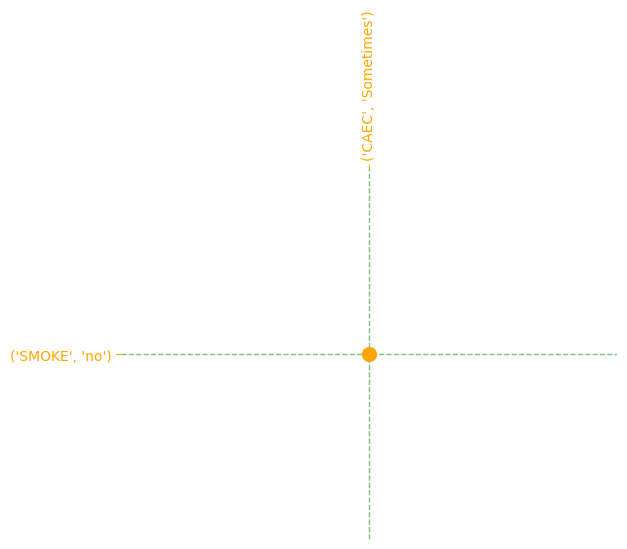

In [26]:
categorical_categorical_catplot_df = get_single_association(distyled_categorical_categorical_apriori)


colors=['green','grey','orange']
catscatter(categorical_categorical_catplot_df,'LHS','RHS','confidence', color=colors,ratio=100)


### Numerical - Numerical CatPlot

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

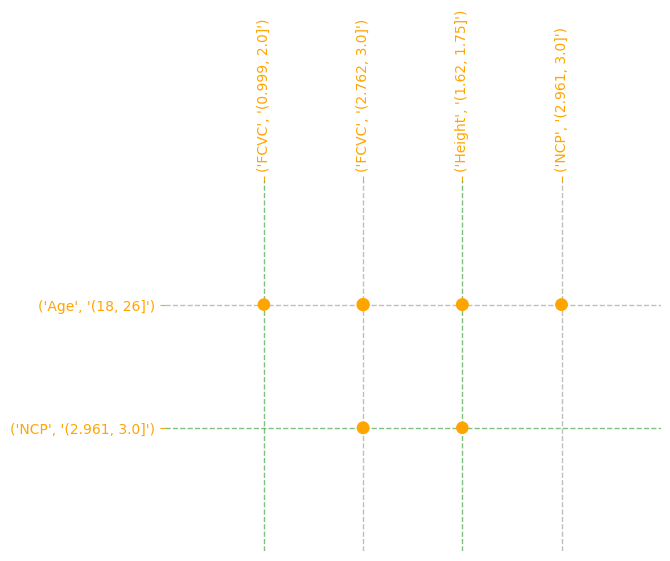

In [27]:
numerical_numerical_catplot_df = get_single_association(distyled_numerical_numerical_apriori)


colors=['green','grey','orange']
catscatter(numerical_numerical_catplot_df,'LHS','RHS','confidence', color=colors,ratio=100)


### Categorical - categorial visualisations

R[write to console]: In addition: 
R[write to console]: There were 23 warnings (use warnings() to see them)
R[write to console]: 



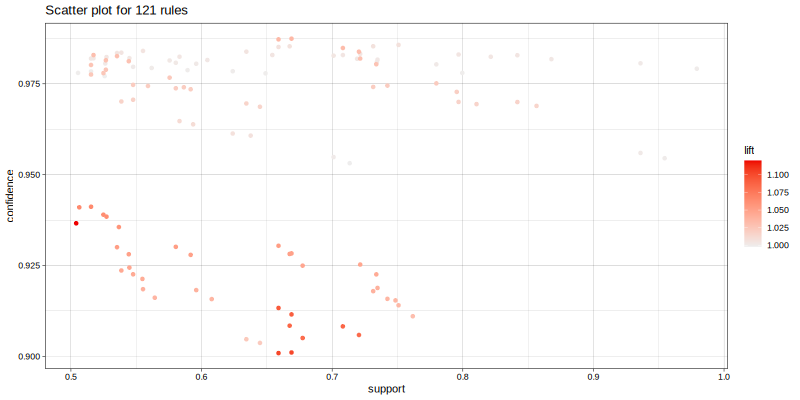

In [28]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.5, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="scatter")
image_png(gg)

In [36]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.7, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

#gg = plot(rules, method="grouped")
#image_png(gg)

R[write to console]: Error in `levels<-`(`*tmp*`, value = as.character(levels)) : 
  factor level [7] is duplicated

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Column(s) 1, 2, 3, 4, 5, 6, 7, 8, 9 not logical or factor. Applying default discretization (see '? discretizeDF'). 



RRuntimeError: Error in `levels<-`(`*tmp*`, value = as.character(levels)) : 
  factor level [7] is duplicated


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Column(s) 1, 2, 3, 4, 5, 6, 7, 8, 9 not logical or factor. Applying default discretization (see '? discretizeDF'). 



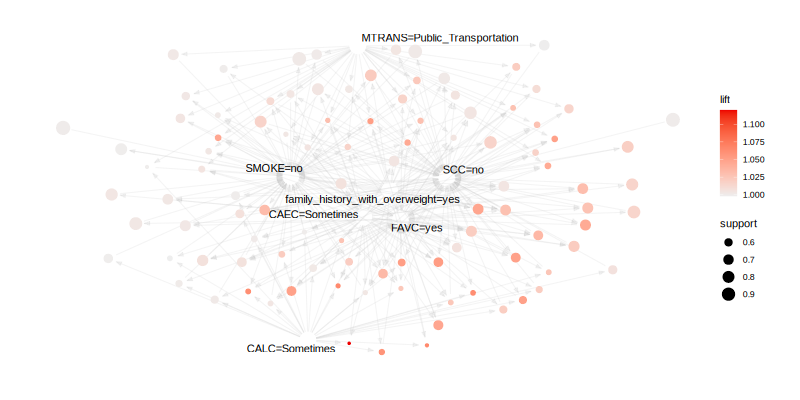

In [33]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.5, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:100]
gg = plot(rules_20, method="graph")
image_png(gg)

### Numerical - numerical visualisations

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Column(s) 1, 2, 3, 4, 5, 6, 7, 8 not logical or factor. Applying default discretization (see '? discretizeDF'). 

R[write to console]: 2: 
R[write to console]: In discretize(x = c(3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,  :
R[write to console]: 
 
R[write to console]:  The calculated breaks are: 1, 3, 3, 4
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.



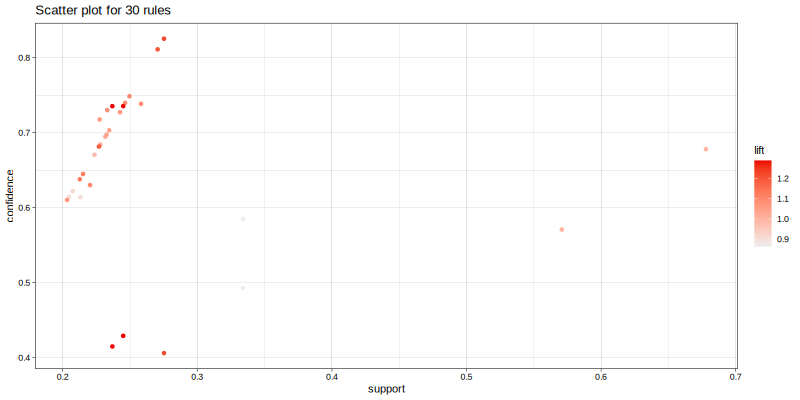

In [32]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.4}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="scatter")
image_png(gg)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Column(s) 1, 2, 3, 4, 5, 6, 7, 8 not logical or factor. Applying default discretization (see '? discretizeDF'). 

R[write to console]: 2: 
R[write to console]: In discretize(x = c(3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,  :
R[write to console]: 
 
R[write to console]:  The calculated breaks are: 1, 3, 3, 4
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.



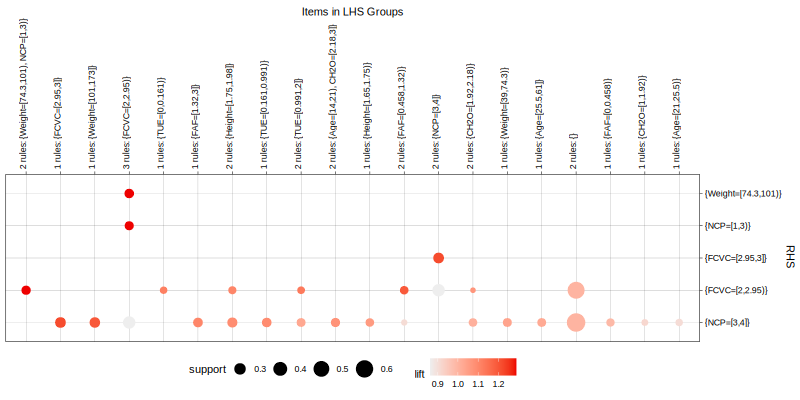

In [31]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.4}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="grouped")
image_png(gg)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Column(s) 1, 2, 3, 4, 5, 6, 7, 8 not logical or factor. Applying default discretization (see '? discretizeDF'). 

R[write to console]: 2: 
R[write to console]: In discretize(x = c(3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,  :
R[write to console]: 
 
R[write to console]:  The calculated breaks are: 1, 3, 3, 4
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.



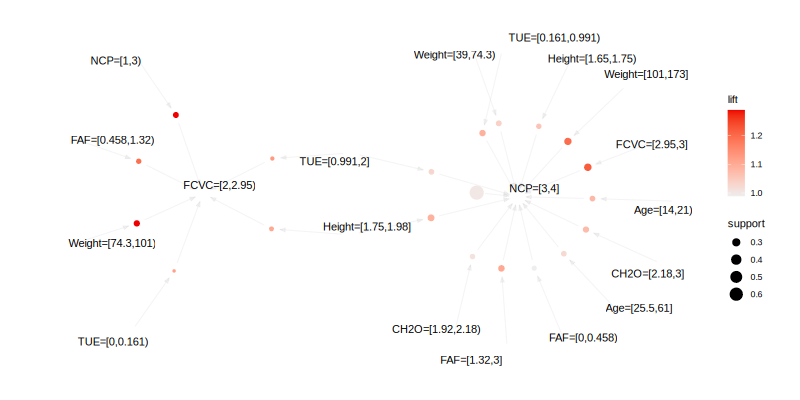

In [30]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.2}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:20]
gg = plot(rules_20, method="graph")
image_png(gg)

### Categorical + numerical - categorical + numerical visualisations

In [ ]:
dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.4}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="scatter")
image_png(gg)

In [ ]:
dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.2}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:20]
gg = plot(rules_20, method="graph")
image_png(gg)

In [ ]:
dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.2}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:20]
gg = plot(rules_20, method="graph")
image_png(gg)

### Catscatter

In [ ]:
catlabel_df_catscat = get_single_association(catlabel_df)


colors=['green','grey','orange']
catscatter(catlabel_df_catscat,'LHS','RHS','confidence', color=colors,ratio=100)


In [ ]:
numlabel_df_catscat = get_single_association(numlabel_df)


colors=['green','grey','orange']
catscatter(numlabel_df_catscat,'LHS','RHS','confidence', color=colors,ratio=100)
